# A simple circuit using PDK components

In this notebook we will use the components in the PDK to build a MZI circuit.

## Preparing your environment

First add the ipkiss PDK location to sys.path if it is not included in PYTHONPATH:

In [1]:
import sys
sys.path.append('H:/GitHub/asp_sin_lnoi_photonics/ipkiss') # Change this to the location of the PDK

We also need to tell ipython to plot figures inline

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Then import the technology settings and ipkiss

In [3]:
import asp_sin_lnoi_photonics.technology
import ipkiss3.all as i3
import asp_sin_lnoi_photonics.all as asp_LNOI
import numpy as np
import matplotlib.pyplot as plt

## Build a MZI

Create the MZI using `MZIWaveguides` class in Picazzo. We use the predefined MMI's in the PDK as the splitter and combiner for the MZI.  

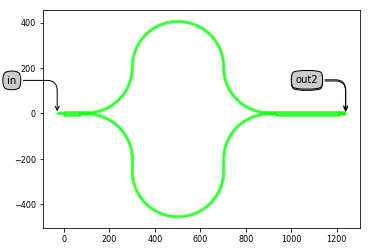

In [4]:
from picazzo3.filters.mzi import MZIWaveguides

splitter = asp_LNOI.MMI1X2_TE1550_RIB()
combiner = asp_LNOI.MMI2X2_TE1550_RIB()

mzi = MZIWaveguides(name="mzi",
                    splitter=splitter,
                    combiner=combiner,
                    splitter_port_names=['out1','out2'],
                    combiner_port_names=['in1','in2'],
                    external_port_names = {"splitter:in":"in",
                                           "combiner:out1":"out1",
                                           "combiner:out2":"out2"}
                   )
mzi_layout = mzi.Layout(delay_length=100.0)

mzi_layout.visualize(annotate=True)

## Attach input/output grating couplers

Let add input and output grating couplers from the PDK and connect them to the MZI using PICAZZO3 `PlaceAndAutoRoute`

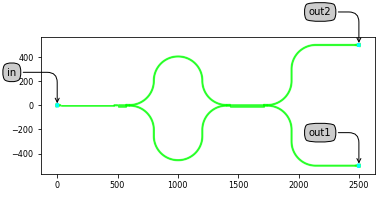

H:\Research\Synthetic_dimensions\github\modulated_ring_layout_two_chips\mzi_circuit.gds

In [5]:
from picazzo3.routing.place_route import PlaceAndAutoRoute

gc_wire = asp_LNOI.GRATING_COUPLER_TE1550_RIBZ()

mzi_circuit = PlaceAndAutoRoute(name="mzi_circuit",
                                child_cells={"in_grating": gc_wire,
                                             "out_grating1": gc_wire, 
                                             "out_grating2": gc_wire, 
                                             "mzi": mzi},          
                                links=[("in_grating:out", "mzi:in"), 
                                       ("out_grating1:out", "mzi:out1"),
                                       ("out_grating2:out", "mzi:out2")],
                                external_port_names = {"in_grating:vertical_in":"in",
                                                       "out_grating1:vertical_in":"out1",
                                                       "out_grating2:vertical_in":"out2"}
                                )


mzi_circuit_layout = mzi_circuit.Layout(child_transformations={"in_grating": i3.Rotation(rotation=0) + i3.Translation((0.0, 0.0)),
                                                             "mzi": i3.Rotation(rotation=0) + i3.Translation((500, 0)),
                                                             "out_grating1": i3.Rotation(rotation=180) + i3.Translation((2500.0, -500.0)),
                                                             "out_grating2": i3.Rotation(rotation=180) + i3.Translation((2500.0, 500.0))
                                                              })
mzi_circuit_layout.visualize(annotate=True)
mzi_circuit_layout.write_gdsii("mzi_circuit.gds")

## Simulate the circuit

We can also simulate this circuit. Here we use `CapheModelFromLayout` for two arms of the MZI so that the lengths the two arms are calculated automatically from their layouts.  

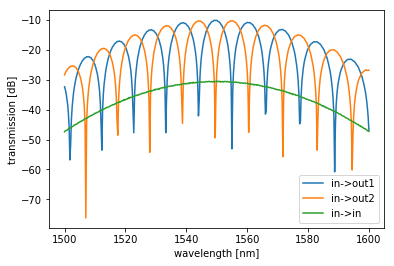

In [6]:
mzi_circuit_cm = mzi_circuit.CircuitModel()

sim_wavelengths = np.linspace(1.5, 1.6, 401)
sm = mzi_circuit_cm.get_smatrix(wavelengths=sim_wavelengths)

plt.figure()
plt.plot(sim_wavelengths*1e3, 10*np.log10(np.abs(sm['in', 'out1'])**2), label='in->out1')
plt.plot(sim_wavelengths*1e3, 10*np.log10(np.abs(sm['in', 'out2'])**2), label='in->out2')
plt.plot(sim_wavelengths*1e3, 10*np.log10(np.abs(sm['in', 'in'])**2), label='in->in')
plt.xlabel('wavelength [nm]')
plt.ylabel('transmission [dB]')
plt.legend()
plt.show()